In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import torch
from PFSP import pfspStep, getCmax, getMeanCmax, getMinCmax, lowerBound
from PFSPNet import gen_data

from itertools import permutations
from random import shuffle

# 示例

In [2]:
# 示例
P = torch.tensor(
    [[
        [85, 53, 45, 76, 38],
        [93, 72, 85, 72, 43],
        [36, 89, 41, 35, 72],
        [63, 63, 94, 42, 86],
        [78, 95, 70, 45, 48],
        [74, 57, 56, 33, 84.0],
    ]]
)
pi = [0, 1, 3, 5, 2, 4]

In [3]:
getCmax(pi, P)

tensor([761.])

In [4]:
getMinCmax(P)

tensor([654.])

In [5]:
getMeanCmax(P)

tensor([733.5990])

# 随机观察分布

In [6]:
n = 7
m = 20
P, state = gen_data(1000, n, m)
if torch.cuda.is_available():
    P, state = P.cuda(), state.cuda()

In [7]:
cmaxs = []
for i in range(1000):
    pi = list(range(n))
    shuffle(pi)
    cmaxs.append(getCmax(pi, P, state).view(1, -1))
cmaxs = torch.cat(cmaxs, dim=0)

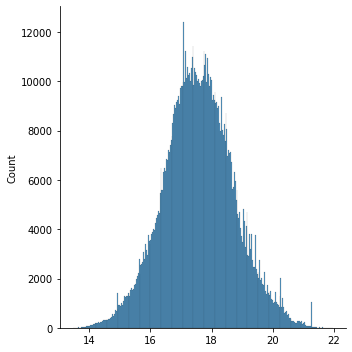

In [10]:
sn.displot(cmaxs.view(-1).cpu())

In [11]:
print('下界: ', lowerBound(P, state).mean().item())
print('随机期望: ', getMeanCmax(P, state).mean().item())
print('准确最优值: ', getMinCmax(P, state).mean().item())

下界:  15.867410659790039
随机期望:  17.588563919067383
准确最优值:  16.791059494018555


In [12]:
def getInfo(n):
    P, state = gen_data(1000, n, 20)
    if torch.cuda.is_available():
        P, state = P.cuda(), state.cuda()
    with torch.no_grad():
        lb = lowerBound(P, state).mean().item()
        if n < 8:
            minCmax = getMinCmax(P, state).mean().item()
        mean = getMeanCmax(P, state).mean().item()
    if n < 8:
        return lb, minCmax, mean
    else:
        return lb, mean


In [13]:
lbs = []
minCmaxs = []
means = []

n = np.array(range(2, 8))

for i in n:
    lb, minCmax, mean = getInfo(i)
    lbs.append(lb)
    minCmaxs.append(minCmax)
    means.append(mean)

In [14]:
lbs = np.array(lbs)
minCmaxs = np.array(minCmaxs)
means = np.array(means)

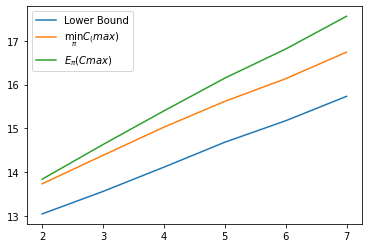

In [15]:
plt.plot(n, lbs, label='Lower Bound')
plt.plot(n, minCmaxs, label='$\min_\pi C_(max)$')
plt.plot(n, means, label='$E_\pi(Cmax)$')
plt.legend();

In [38]:
from scipy.optimize import minimize

def aim(x):
    y = x[0] * n + x[1] * lbs + x[2] * means
    loss = ((y - minCmaxs)**2).sum()
    
    return loss

res = minimize(aim, np.array([1, 1, 1]))

In [46]:
lbs = []
means = []

n = np.array(range(8, 21))

for i in n:
    lb, mean = getInfo(i)
    lbs.append(lb)
    means.append(mean)
lbs = np.array(lbs)
means = np.array(means)

In [47]:
PreminCmax = res.x[0] * n + res.x[1] * lbs + res.x[2] * means

$\min C_{max}$ 预期：

  2:13.733311653137207
  
  3:14.384550094604492
  
  4:15.02747917175293
  
  5:15.616798400878906
  
  6:16.13387680053711
  
  7:16.74065399169922

  8:17.360736402949584

  9:17.834100394416716

 10:18.373637074557184

 11:18.96397661232485

 12:19.436947242532376

 13:19.936470671394456

 14:20.506111830260146

 15:21.01352662015546

 16:21.487658386495347

 17:21.995560488268183

 18:22.47925392587566
 
 19:23.001928887200457